For this first trial we assume a naive model (LGM) defined as:
$$dx_t = \sigma_t dW_t^{\mathit{N}}$$

Let's define the Numeraire as:
$$N(t, x_t) = \frac{1}{B(0,t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where $H_t$ and $\zeta_t$ are known functions.

With this let's defined the fundamental equation for the pricing of a derivative under the model. The NPV (Net Present Value) is:
$$V_t = V(t, x_t)$$ 
and the deflated version 
$$\overline{V}_t = V(t, x_t) / N(t, x_t)$$

#### Montecarlo simulation

* Brownian path:
$$W_t \sim \mathcal{N}(0,t)$$
$$W[0] = X_0$$
$$W[t] = W[t - 1]  + \mathcal{Z} \cdot \Delta t^{\frac{1}{2}}$$
with 
$$\mathcal{Z} \sim \mathcal{N}(0,1)$$
* X:
$$X_{t + 1} = X_t + \sigma \cdot (W_{t + 1} - W_t)$$

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from utils.simulator.simulator import MCSimulation

In [2]:
# Strike value
Vt = 2
T = 8
# Set of parameters
T, N_steps, X0, sigma = (T, 100, 0, 0.01)
mcsimulator = MCSimulation(T, N_steps, X0, sigma)
nsims = int(1e3)
test_sims = int(nsims * 0.2)
# Training
mc_paths, W = mcsimulator.simulate(nsims)
mc_paths_transpose = mc_paths.T
mc_paths_flatten = mc_paths.flatten('C')
w_paths_flatten = W.flatten('C')
# Test
mc_paths_test, W_test = mcsimulator.simulate(test_sims)
mc_paths_test_transpose = mc_paths_test.T
mc_paths_test_flatten = mc_paths_test.flatten('C')
w_paths_test_flatten = W_test.flatten('C')
# Deltas
deltaTs = np.linspace(0, T, N_steps)
simulations = np.linspace(0, nsims - 1, nsims)
simulations = np.int32(np.tile(simulations, N_steps))
deltaTs = np.tile(deltaTs.reshape(N_steps, 1), nsims).flatten()
df_x = pd.DataFrame(zip(
    deltaTs,
    mc_paths_flatten,
    w_paths_flatten,
    simulations
), columns = ['dt',
              'xt',
              'wt',
              'simulation'])

#### Visualization

In [3]:
deltaTs = np.linspace(0, T, N_steps)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
if nsims < 101:
    plt.figure(figsize = (15,6))
    plt.title('Complete set of paths')
    sns.lineplot(x = 'dt', y = 'xt', hue = 'simulation', data = df_x)
    plt.show()
    plt.figure(figsize = (15,6))
    plt.title('Complete paths distribution')
    sns.regplot(x = 'dt', y = 'xt', data = df_x, scatter = False)
    plt.show()

#### Tests with IRS

An IRS, interes rate swap, is a swap between two institutions that decide to interchange interest rates. One of the pays a fixed part while the other pays a variable part. The final objective is allow the two parts, institutions, to be safe against risky fluctuations in interest rates.

As starting point let's remember two basic concepts:
* Numeraire, or take to zero the option, IRS or one particular value.
* Zero Bond coupon, the most basic coupon, it pays one at strike time.

Numeraire: 

$$N(t, x_t) = \frac{1}{D(t)}exp^{H_tx_t + \frac{1}{2}H_t^2\zeta_t}$$
where:
* $D(t)$ discount factor and can be calculated as $D(t) = e^{-rt}$, in the examples ahead we stick to a $r = 0.03$
* $H(t) = \frac{1 - e^{-\kappa t}}{\kappa}$, with $\kappa = 2$

Zero Bond coupon:

$$Z(x_t, t, T) = D(T)exp(-\frac{1}{2}H_T^2\zeta_t-H_Tx_t)N(t, x_t)$$
where:
* $\zeta(t) = \int_0^t\sigma^2(s)ds$, with $\sigma(s)$ a piecewise function.

From here we can develop the equation that defines an IRS, interest rate swap.

$$V(T) = 1 - Z(x_T, T, T_N) - \mathcal{T} \sum_{i = 1}^n \tau_i Z(x_T, T, T_i)$$

where:
* $1 - Z(x_T, T, T_N)$ is the variable part of the IRS.
* $\mathcal{T} \sum_{i = 1}^n \tau_i Z(x_T, T, T_i)$ defines the fixed part of the IRS.
* $\mathcal{T}$ is the fixed interest rate.
* $\tau_i$ represents the fraction of the fixed part of the IRS that is paid at the time $T_i$.

From here we can easily derivate the IRS Swaption as:
$$V(T) = max(\phi(1 - Z(x_T, T, T_N) - \mathcal{T} \sum_{i = 1}^n \tau_i Z(x_T, T, T_i)), 0 )$$

#### Feed Forward neural networks

The next sections aims to build the technical part of the project:
* Neural network architecture
* Evaluation method

In [5]:
# Tf imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

keras.backend.clear_session() 
keras.backend.set_floatx('float64')
tf.executing_eagerly()

True

### Single step model

In [6]:
from utils.utils.utils import MLUtils
dts = list(np.linspace(0, T, N_steps)) * len(mc_paths_transpose)
simulation = [
    [i] * N_steps for i in range(nsims)
]
df_x_tmp = pd.DataFrame(
    zip(
        mc_paths_transpose,
        simulation
    ),
    columns = [
        'path',
        'simulation'
    ]
)
df_x = pd.DataFrame()
df_x['xt'] = df_x_tmp.explode('path')['path']
df_x['dt'] = dts
df_x['simulation'] = df_x_tmp.explode('simulation')['simulation']
df_x['_delta_x'] = df_x.groupby([
    'simulation',
])['xt'].shift(1)
df_x['_delta_x'] = (df_x['xt'] - df_x['_delta_x'])
df_x.loc[df_x._delta_x.isna(), '_delta_x'] = 0.
# Sort to get the examples in blocks
df_x.sort_values(
    [
        'simulation',
        'dt'
    ],
    inplace = True
)

Features shape: (100000, 2)
Batch size: 100 paths per epoch with length 100
T: 8
Positions to avoid from V 100.0
Positions to complete from V 100.0
Model: "irs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_nn (InputLayer)       [(None, 2)]               0         
                                                                 
 internal_relu_dense_0 (Dens  (None, 32)               96        
 e)                                                              
                                                                 
 internal_relu_dense_1 (Dens  (None, 32)               1056      
 e)                                                              
                                                                 
 internal_relu_dense_2 (Dens  (None, 32)               1056      
 e)                                                              
                                               

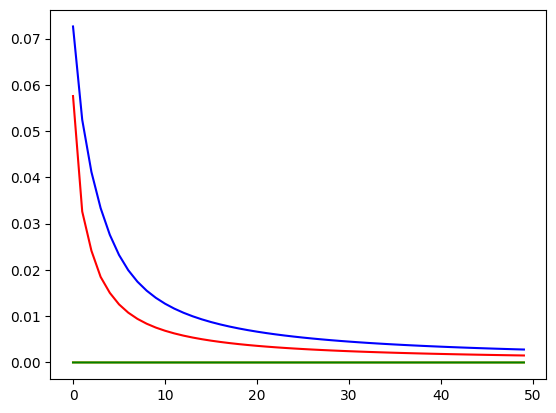

In [7]:
import time
import sys
from model.model_lgm_single_step import LGM_model_one_step
from utils.utils.utils import IRS

epochs = 50
mc_paths_tranformed = df_x[['xt', 'dt']].values
# Data used as features
x = mc_paths_tranformed.astype(np.float64)
delta_x = df_x._delta_x.values.astype(np.float64)
print(f'Features shape: {x.shape}')
# Batch execution with baby steps
size_of_the_batch = 100
batch_size = size_of_the_batch * N_steps
batches = int(np.floor(nsims * N_steps / batch_size))
print(f'Batch size: {size_of_the_batch} paths per epoch with length {N_steps}')
# Custom model
lgm_single_step = LGM_model_one_step(n_steps = N_steps, 
                                     T = T, 
                                     future_T = 2 * T,
                                     verbose = False,
                                     sigma = sigma,
                                     batch_size = size_of_the_batch,
                                     phi = IRS.IRS_normalized,
                                     name = 'irs'
)
print(f'{lgm_single_step.summary()}')
# Compile the model
lgm_single_step.define_compiler(optimizer = 'adam', learning_rate = 1e-3)
# Losses:
losses_split = {
    'total': [],
    'strike_loss': [],
    'strike_derivative_loss': [],
    'steps_error': []
}
# Custom iteration: 
start_time = time.time()
for epoch in range(epochs):
    print(f'{epoch}...', end = '')
    dimension = (1, batches)
    total_tmp, strike_tmp, derivative_tmp, steps_tmp = (
        np.zeros(dimension),
        np.zeros(dimension),
        np.zeros(dimension),
        np.zeros(dimension)
    )
    for batch in range(batches):
        x_batch = x[batch * batch_size: (batch + 1) * batch_size, :]
        delta_x_batch = delta_x[batch * batch_size: (batch + 1) * batch_size]
        el, sl, sdl, se = lgm_single_step.custom_train_step(
            X = x_batch,
            batch = batch,
            epoch = epoch, 
            start_time = start_time,
            delta_x = delta_x_batch)
        # Store partial results
        total_tmp[0, batch] = el
        strike_tmp[0, batch] = sl
        derivative_tmp[0, batch] = sdl
        steps_tmp[0, batch] = se
    losses_split['total'].append(
        el
    )
    losses_split['strike_loss'].append(
        sl
    )
    losses_split['strike_derivative_loss'].append(
        sdl
    )
    losses_split['steps_error'].append(
        se
    )
# Visualize errors
plt.figure()
sns.lineplot(x = [i for i in range(epochs)], 
             y = losses_split['total'], 
             color = 'blue')
sns.lineplot(x = [i for i in range(epochs)], 
             y = losses_split['strike_loss'],
             color = 'red')
sns.lineplot(x = [i for i in range(epochs)], 
             y = losses_split['strike_derivative_loss'],
             color = 'orange')
sns.lineplot(x = [i for i in range(epochs)], 
             y = losses_split['steps_error'],
             color = 'green')
plt.show()

#### Visual Evaluation

In [ ]:
dts = list(np.linspace(0, T, N_steps)) * len(mc_paths_test_transpose)
simulation = [
    [i] * N_steps for i in range(test_sims)
]
df_x_tmp = pd.DataFrame(
    zip(
        mc_paths_test_transpose,
        simulation
    ),
    columns = [
        'path',
        'simulation'
    ]
)
df_x = pd.DataFrame()
df_x['xt'] = df_x_tmp.explode('path')['path']
df_x['dt'] = dts
df_x['simulation'] = df_x_tmp.explode('simulation')['simulation']
df_x['_delta_x'] = df_x.groupby([
    'simulation',
])['xt'].shift(1)
df_x['_delta_x'] = (df_x['xt'] - df_x['_delta_x'])
df_x.loc[df_x._delta_x.isna(), '_delta_x'] = 0.
# Sort to get the examples in blocks
df_x.sort_values(
    [
        'simulation',
        'dt'
    ],
    inplace = True
)
# Adjust x
mc_paths_tranformed = df_x[['xt', 'dt']].values.astype(np.float64)
delta_x = df_x._delta_x.values.astype(np.float64)
# mc_paths_tranformed = np.reshape(mc_paths_tranformed, (N_steps * nsims, 2)).T
# Data used as features
x = mc_paths_tranformed.astype(np.float64)
x = tf.constant(x)
v_lgm_single_step, predictions = lgm_single_step.predict(x, 
                                                         delta_x,
                                                         build_masks = True)
# Adapt output
results = pd.DataFrame(
    zip(v_lgm_single_step),
    columns = ['results']
)
v_lgm_single_step = results.explode('results').values
df_x['lgm_single_step_V'] = v_lgm_single_step.astype(np.float64)
v_df = pd.DataFrame(
    zip(df_x.lgm_single_step_V.values,
        df_x.dt.values, 
        df_x.xt.values,
        df_x.simulation.values), 
    columns = ['V_hat_single_step', 
               'deltat', 
               'xt',
               'simulation']
    )

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (5, 5))
sns.lineplot(
    x = 'deltat',
    y = 'V_hat_single_step',
    color = 'blue',
    hue = 'simulation',
    data = v_df
)
plt.ylim(0, 1)
plt.show()

In [ ]:
from utils.utils.utils import FinanceUtils
# Calcule cts
t_unique = v_df.deltat.unique()
dict_C = {dt:FinanceUtils.C(dt, sigma_value = sigma) for dt in t_unique}
v_df['ct'] = v_df.apply(lambda x: dict_C[x['deltat']], axis = 1)
v_df.head()
# Value IRS
n_sims_test = int(v_df.shape[0] / N_steps)
x_reformat = tf.reshape(v_df.xt, (n_sims_test, N_steps))
xn_tensor = x_reformat[:, -1]

c_reformat = tf.reshape(v_df.ct, (n_sims_test, N_steps))
c_tensor = c_reformat[:, -1]
print(f'IRS value: {IRS.IRS_normalized(xn_tensor, np.float64(T), 2 * np.float64(T), c_tensor)}')